## Download and install requisite libraries and packages
---

In [1]:
import sys

!{sys.executable} -m pip install -U mxnet
!{sys.executable} -m pip install -U nltk
!{sys.executable} -m pip install -U numpy
!{sys.executable} -m pip install -U spacy
!{sys.executable} -m pip install -U pandas
!{sys.executable} -m pip install -U pillow
!{sys.executable} -m pip install -U plotly
!{sys.executable} -m pip install -U seaborn
!{sys.executable} -m pip install -U wordcloud
!{sys.executable} -m pip install -U matplotlib
!{sys.executable} -m pip install -U advertools
!{sys.executable} -m pip install -U autocorrect
!{sys.executable} -m pip install -U scikit-learn
!{sys.executable} -m pip install -U psutil requests
!{sys.executable} -m pip install -U datetime_truncate
!{sys.executable} -m pip install jupyterlab "ipywidgets>=7.5"
# !{sys.executable} -m pip install "notebook>=5.3" "ipywidgets>=7.5"

     |████████████████████████████████| 46.9 MB 129 kB/s  eta 0:00:01
     |████████████████████████████████| 1.5 MB 18.3 MB/s eta 0:00:01
     |████████████████████████████████| 75 kB 932 kB/s  eta 0:00:01
  Attempting uninstall: nltk
    Found existing installation: nltk 3.4.4
    Uninstalling nltk-3.4.4:
      Successfully uninstalled nltk-3.4.4
     |████████████████████████████████| 12.9 MB 12.2 MB/s eta 0:00:01
     |████████████████████████████████| 9.2 MB 68.5 MB/s eta 0:00:01
     |████████████████████████████████| 456 kB 66.2 MB/s eta 0:00:01
     |████████████████████████████████| 42 kB 246 kB/s  eta 0:00:01
     |████████████████████████████████| 9.8 MB 69.7 MB/s eta 0:00:01
     |████████████████████████████████| 126 kB 21.4 MB/s eta 0:00:01
     |████████████████████████████████| 620 kB 71.6 MB/s eta 0:00:01
     |████████████████████████████████| 113 kB 72.2 MB/s eta 0:00:01
  Created wheel for smart-open: filename=smart_open-3.0.0-py3-none-any.whl size=107097 sha256=6c1

### JupyterLab renderer support
install the required JupyterLab extensions

In [2]:
!conda install -c conda-forge nodejs -y
!conda install -c plotly plotly-orca -y

Solving environment: - 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - conda-forge/noarch::seaborn-base==0.11.1=pyhd8ed1ab_1
  - conda-forge/noarch::nbclassic==0.2.6=pyhd8ed1ab_0
  - conda-forge/linux-64::blaze==0.11.3=py36_0
  - conda-forge/linux-64::matplotlib==3.3.4=py36h5fab9bb_0
  - defaults/linux-64::_anaconda_depends==5.1.0=py36_2
  - conda-forge/noarch::jupyterlab==3.0.9=pyhd8ed1ab_0
  - conda-forge/noarch::python-language-server==0.36.2=pyhd8ed1ab_0
  - conda-forge/noarch::jupyterlab_server==2.3.0=pyhd8ed1ab_0
  - conda-forge/noarch::pyls-black==0.4.6=pyh9f0ad1d_0
  - conda-forge/linux-64::scikit-image==0.16.2=py36hb3f55d8_0
  - conda-forge/noarch::black==20.8b1=py_1
  - conda-forge/linux-64::anyio==2.1.0=py36h5fab9bb_0
  - conda-forge/linux-64::jupyter_server==1.4.1=py36h5fab9bb_0
  - conda-forge/linux-64::bokeh==2.2.3=py36h5fab9bb_0
  - conda-forge/noarch::aiobotocore==1.2.1=pyhd8ed1ab_0
  -

In [3]:
!jupyter labextension install jupyterlab-plotly

Config option `kernel_spec_manager_class` not recognized by `InstallLabExtensionApp`.
[W 2021-06-25 01:11:27.552 LabApp] Config option `kernel_spec_manager_class` not recognized by `LabApp`.
Building jupyterlab assets (production, minimized)


In [3]:
import matplotlib.pyplot as plt
import plotly.express as px
import wordcloud as wc
import seaborn as sns
import pandas as pd 
import numpy as np
import mxnet as mx
import tarfile
import zipfile
import sklearn
import os
from datetime_truncate import truncate

## Import and prepare CSV files
---

In [140]:
gps_df = pd.read_csv('data/play_store_reviews.csv')
as_df = pd.read_csv('data/app_store_reviews.csv')
combined_df = pd.read_csv('data/combined_reviews.csv')

# convert date columns to datetime since dtypes aren't preserved in csv files
gps_df['at'] = pd.to_datetime(gps_df['at'])
as_df['date'] = pd.to_datetime(as_df['date'])
combined_df['date'] = pd.to_datetime(combined_df['date'])

In [141]:
# drop unnecessary columns
gps_df = gps_df.drop(['reviewId', 'userName', 'userImage', 'thumbsUpCount', 'reviewCreatedVersion', 'replyContent', 'repliedAt'], axis=1)
gps_df['type'] = 'play store'

gps_df.info()
print(display(gps_df.head(10)))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110606 entries, 0 to 110605
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype         
---  ------   --------------   -----         
 0   content  110597 non-null  object        
 1   score    110606 non-null  int64         
 2   at       110606 non-null  datetime64[ns]
 3   type     110606 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 3.4+ MB


,content,score,at,type
0,Friendly user.,5,2020-08-05 06:23:06,play store
1,nice and easy,5,2021-05-07 12:10:07,play store
2,Amazing gcash,5,2021-04-11 06:13:37,play store
3,Nice apps ever last thing 🔥🔥🔥🔥🔥😍😍😍😍😍😘😘😘😘😘,5,2021-02-26 01:45:39,play store
4,Very convinience,5,2020-08-02 04:48:25,play store
5,wow,5,2020-03-30 03:43:02,play store
6,Excellent,5,2020-10-22 15:58:33,play store
7,Kkkkkkkk,5,2020-10-25 05:57:47,play store
8,Nice,5,2021-03-06 12:42:25,play store
9,vgood,5,2021-04-06 07:14:31,play store


None


In [142]:
as_df = as_df.drop(['title', 'userName', 'isEdited', 'developerResponse'], axis=1)
as_df['type'] = 'app store'

as_df.info()
print(display(as_df.head(10)))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1669 entries, 0 to 1668
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    1669 non-null   datetime64[ns]
 1   review  1669 non-null   object        
 2   rating  1669 non-null   int64         
 3   type    1669 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 52.3+ KB


,date,review,rating,type
0,2021-02-17 06:32:13,Nakakadismaya naman. Dati okay naman yung gcas...,1,app store
1,2020-03-24 03:28:48,Don’t ever put your money here! My transaction...,1,app store
2,2020-09-15 16:58:57,Best as it has no fees. Wish they had rebates ...,5,app store
3,2020-06-07 09:31:21,Gcash has been very helpful in many ways to me...,1,app store
4,2020-09-25 09:19:47,I USED METROBANK INSTAPAY TO CASH IN BUT UNTIL...,1,app store
5,2021-01-31 02:22:08,My account was charged without the transaction...,1,app store
6,2020-07-22 08:00:54,you've alway have deductions everytime we have...,1,app store
7,2020-04-20 19:30:59,So the first time I used this app they ask me ...,1,app store
8,2020-06-16 13:13:06,please fix this problem for the first time use...,1,app store
9,2020-12-09 06:42:52,I sent wrong number pls help me to refund my m...,5,app store


None


In [ ]:
# init empty DF
combined_df = pd.DataFrame()

# populate lists
date_lst = gps_df['at'].values.tolist() + as_df['date'].values.tolist()
review_lst = gps_df['content'].values.tolist() + as_df['review'].values.tolist()
rating_lst = gps_df['score'].values.tolist() + as_df['rating'].values.tolist()
type_lst = gps_df['type'].values.tolist() + as_df['type'].values.tolist()

# populate DF
combined_df['date'] = date_lst
combined_df['date'] = pd.to_datetime(combined_df['date'])
combined_df['review'] = review_lst
combined_df['rating'] = rating_lst
combined_df['type'] = type_lst

# shuffle rows
combined_df = combined_df.sample(frac=1).reset_index(drop=True)

# drop rows that have NULL entries
combined_df = combined_df.dropna()

# drop rows that have duplicates
combined_df = combined_df.drop_duplicates()

combined_df.info()
print(display(combined_df.head(10)))

### Export combined_df as CSV

In [ ]:
combined_df.to_csv('data/combined_reviews.csv', index=False)

In [4]:
combined_df = pd.read_csv('data/combined_reviews.csv')

# convert date columns to datetime since dtypes aren't preserved in csv files
combined_df['date'] = pd.to_datetime(combined_df['date'])

# create and append month column
combined_df['month'] = combined_df['date'].apply(lambda x: truncate(x, 'month').date())
combined_df['month'] = pd.to_datetime(combined_df['month'])

combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112264 entries, 0 to 112263
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    112264 non-null  datetime64[ns]
 1   review  112264 non-null  object        
 2   rating  112264 non-null  int64         
 3   type    112264 non-null  object        
 4   month   112264 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(2)
memory usage: 4.3+ MB


## Exploratory Data Analysis
---

In [44]:
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# set default renderer
pio.renderers.default = "iframe"

# disable false positive warning
pd.options.mode.chained_assignment = None  # default='warn'

ax_1 = combined_df.loc[(combined_df['type'] == 'play store') & (combined_df['rating'] == 1)]
ax_5 = combined_df.loc[(combined_df['type'] == 'play store') & (combined_df['rating'] == 5)]
ax_1 = ax_1.sort_values(by=['date'])
ax_5 = ax_5.sort_values(by=['date'])
ax_1['cumsum'] = ax_1['rating'].eq(1).cumsum()
ax_5['cumsum'] = ax_5['rating'].eq(5).cumsum()
ax_1_ratings = ax_1.groupby(['month', 'rating'])['review'].count().reset_index()
ax_5_ratings = ax_5.groupby(['month', 'rating'])['review'].count().reset_index()

bx_1 = combined_df.loc[(combined_df['type'] == 'app store') & (combined_df['rating'] == 1)]
bx_5 = combined_df.loc[(combined_df['type'] == 'app store') & (combined_df['rating'] == 5)]
bx_1 = bx_1.sort_values(by=['date'])
bx_5 = bx_5.sort_values(by=['date'])
bx_1['cumsum'] = bx_1['rating'].eq(1).cumsum()
bx_5['cumsum'] = bx_5['rating'].eq(5).cumsum()
bx_1_ratings = bx_1.groupby(['month', 'rating'])['review'].count().reset_index()
bx_5_ratings = bx_5.groupby(['month', 'rating'])['review'].count().reset_index()

fig = make_subplots(
    rows=3, 
    cols=2, 
    shared_xaxes=True,
    vertical_spacing=0.05,
    subplot_titles=("Play Store Review Count Over Time (01/2020 - 06/2021)", "App Store Review Count Over Time (01/2020 - 06/2021)")
)

# Play Store
fig.add_trace(
    go.Scatter(
        x=ax_1['date'],
        y=ax_1['cumsum'],
        name='1-star Play Store',
        marker=dict(color='#4c84ed')
    ),
    row=1, 
    col=1
)
fig.add_trace(
    go.Histogram(
        x=ax_1['date'],
        y=ax_1['rating'],
        name='1-star Play Store',
        marker=dict(color='#4c84ed')
    ),
    row=2, 
    col=1
)
fig.add_trace(
    go.Scatter(
        x=ax_1_ratings['month'],
        y=ax_1_ratings['review'],
        name='1-star Play Store',
        marker=dict(color='#4c84ed')
    ),
    row=3, 
    col=1
)
fig.add_trace(
    go.Scatter(
        x=ax_5['date'],
        y=ax_5['cumsum'],
        name='5-star Play Store',
        marker=dict(color='#ed4c4c')
    ),
    row=1, 
    col=1
)
fig.add_trace(
    go.Histogram(
        x=ax_5['date'],
        y=ax_5['rating'],
        name='5-star Play Store',
        marker=dict(color='#ed4c4c')
    ),
    row=2, 
    col=1
)
fig.add_trace(
    go.Scatter(
        x=ax_5_ratings['month'],
        y=ax_5_ratings['review'],
        name='5-star Play Store',
        marker=dict(color='#ed4c4c')
    ),
    row=3, 
    col=1
)

# App Store
fig.add_trace(
    go.Scatter(
        x=bx_1['date'],
        y=bx_1['cumsum'],
        name='1-star App Store',
        marker=dict(color='#4c84ed')
    ),
    row=1, 
    col=2
)
fig.add_trace(
    go.Histogram(
        x=bx_1['date'],
        y=bx_1['rating'],
        name='1-star App Store',
        marker=dict(color='#4c84ed')
    ),
    row=2, 
    col=2
)
fig.add_trace(
    go.Scatter(
        x=bx_1_ratings['month'],
        y=bx_1_ratings['review'],
        name='1-star App Store',
        marker=dict(color='#4c84ed')
    ),
    row=3, 
    col=2
)
fig.add_trace(
    go.Scatter(
        x=bx_5['date'],
        y=bx_5['cumsum'],
        name='5-star App Store',
        marker=dict(color='#ed4c4c')
    ),
    row=1, 
    col=2
)
fig.add_trace(
    go.Histogram(
        x=bx_5['date'],
        y=bx_5['rating'],
        name='5-star App Store',
        marker=dict(color='#ed4c4c')
    ),
    row=2, 
    col=2
)
fig.add_trace(
    go.Scatter(
        x=bx_5_ratings['month'],
        y=bx_5_ratings['review'],
        name='5-star App Store',
        marker=dict(color='#ed4c4c')
    ),
    row=3, 
    col=2
)

# Update yaxis properties
fig.update_yaxes(title_text="Review Count")
fig.show()

# for graph to persist outside session
# fig.show(renderer="svg", width=1750, height=800, engine='auto')

In [45]:
# init empty DF
cx = pd.DataFrame()

# Collect and store all App Store reviews in a temporary DF
cx = combined_df
cx['Review word count'] = cx['review'].str.count(' ') + 1
print(f"\nMean word count: {cx['Review word count'].mean()}")

fig = px.histogram(
    cx, 
    x='Review word count',
    color='rating',
    labels=['Word count', 'Review count'],
    title='Review Word Count of App Store and Play Store Reviews',
    barmode='group',
    width=1000, 
    height=500
)
fig.show()

# for graph to persist outside session
# fig.show(renderer="png")


Mean word count: 8.828484643340698


### Play Store

In [46]:
# init empty DF
ax = pd.DataFrame()

# Collect and store all Play Store reviews in a temporary DF
# ax = combined_df.loc[(combined_df['type'] == 'play store') & (combined_df['date'] >= '2021-04-09 00:00:00') & (combined_df['date'] <= '2021-04-12 00:00:00')]
ax = combined_df.loc[(combined_df['type'] == 'play store')]
ax['Review word count'] = ax['review'].str.count(' ') + 1

ax_1['Review word count'] = ax_1['review'].str.count(' ') + 1
ax_5['Review word count'] = ax_5['review'].str.count(' ') + 1
print(f"\n1-star reviews mean word count: {ax_1['Review word count'].mean()}")
print(f"5-star reviews mean word count: {ax_5['Review word count'].mean()}")

fig = px.histogram(
    ax, 
    x='Review word count',
    color='rating',
    labels=['Word count', 'Review count'],
    title='Review Word Count of Play Store Reviews',
    barmode='group',
    width=1000, 
    height=500
)
fig.show()

# for graph to persist outside session
# fig.show(renderer="png")


1-star reviews mean word count: 20.143907635214074
5-star reviews mean word count: 4.245419852011829


### App Store

In [47]:
# init empty DF
bx = pd.DataFrame()

# Collect and store all App Store reviews in a temporary DF
bx = combined_df.loc[(combined_df['type'] == 'app store')]
bx['Review word count'] = bx['review'].str.count(' ') + 1

bx_1['Review word count'] = bx_1['review'].str.count(' ') + 1
bx_5['Review word count'] = bx_5['review'].str.count(' ') + 1
print(f"\n1-star reviews mean word count: {bx_1['Review word count'].mean()}")
print(f"5-star reviews mean word count: {bx_5['Review word count'].mean()}")

fig = px.histogram(
    bx, 
    x='Review word count',
    color='rating',
    labels=['Word count', 'Review count'],
    title='Review Word Count of App Store Reviews',
    barmode='group',
    width=1000, 
    height=500
)
fig.show()

# for graph to persist outside session
# fig.show(renderer="png")


1-star reviews mean word count: 35.830862533692724
5-star reviews mean word count: 31.07027027027027


## Convert plain text to bag-of-words (BOW)
---

In [5]:
import re
import nltk
import spacy 
import advertools as adv
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
from spacy.lang.en.stop_words import STOP_WORDS
from nltk.corpus import wordnet, words, stopwords

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

# concatenate english and tagalog stopwords into one list
stop_words = stopwords.words('english') + list(adv.stopwords['tagalog']) + \
            ['gcash', 'could', 'doe', 'might', 'must', 'need', 'sha', \
             'would', 'far', 'nag', 'already', 'always', 'app', 'cant', \
             'dont', 'even', 'get', 'please', 'say', 'still', 'try', 'use', \
             'yung', 'day', 'keep', 'lang', 'like', 'make', 'nyo', 'the', 'to', \
             'ive', 'naman', 'one', 'take', 'fully', 'also', 'amaze', 'app..', \
             'give', 'much', 'okay', 'pag', 'sana', 'star', 'sya', 'thank', \
             'usefull', 'verry', 'wala', 'want', 'way', 'well', 'wow', 'didnt', \
             'every', 'guy', 'hope', 'kayo', 'know', 'let', 'link', 'mag', 'many', \
             'message', 'never', 'nothing', 'open', 'put', 'really', 'seem', 'start', \
             'thing', 'whenever', 'wont', 'wrong', 'yet', 'almost', 'anymore', 'back', \
             'come', 'doesnt', 'especially', 'everytime', 'first', 'globe', 'last', \
             'month', 'new', 'niyo', 'since', 'something', 'think', 'thru', 'ung', \
             'without', 'suppose', 'tapos', 'another', 'anything', 'u', 'thats', \
             'via', 'etc', 'everything', 'everywhere', 'find', 'io', 'life', \
             'list', 'lot', 'maybe', 'meter', 'next' , 'past', 'phone', 'pls', \
             'plus', 'point', 'pwede', 'see', 'show', 'sometimes', 'team', 'whats', \
             'wish', 'year', 'gamitin', 'girl', 'hand', 'happen', 'hello', 'high', \
             'however', 'hurt', 'though', 'true', 'usually', 'screen', 'soon', 'acc', \
             'add', 'yun', 'yes', 'youre', 'coz', 'acct', 'agad', 'line', 'long', 'today', \
             'go', 'abd']

# Helper function to lemmatize with part of speech (POS) tag
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

token_pattern = re.compile(r"(?u)\b\w\w+\b")

class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(word, get_wordnet_pos(word)) for word in word_tokenize(doc) if len(word) >= 3 and re.match("[a-z].*", word) and re.match(token_pattern, word)]

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ec2-user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


### Tokenize and lemmatize review data

In [33]:
import time
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

main_df = combined_df.loc[(combined_df['rating'] == 1) & (combined_df['type'] == 'app store')]

# split data to training (70%), validation (15%), and test (15%) datasets
train_data, val_data = train_test_split(main_df, train_size=0.7, random_state=42)
train_data, test_data = train_test_split(train_data, train_size=0.7, random_state=42) 

print(f'Training, validation, and test data shapes:\n{train_data.shape}')
print(val_data.shape)
print(test_data.shape)

first_batch = train_data.review.values.tolist()
second_batch = val_data.review.values.tolist()
third_batch = test_data.review.values.tolist()

vocab_size = 40

print('\nTokenizing and counting, this may take a few minutes...')
start_time = time.time()
vectorizer = CountVectorizer(
    input='content', 
    analyzer='word', 
    stop_words=stop_words,
    tokenizer=LemmaTokenizer(),
    strip_accents='ascii',
    max_features=vocab_size, 
    max_df=0.95, # maximum document frequency of 95% of documents
    min_df=2 # minimum document frequency of 2 documents
)

# Learn the vocabulary dictionary from the training data and return a document-term matrix
train_vectors = vectorizer.fit_transform(first_batch)
vocab_map = vectorizer.vocabulary_
vocab_list = vectorizer.get_feature_names()
removed_words = vectorizer.get_stop_words()

# Extract token counts out of validation and test datasets using the vocabulary fitted with fit 
val_vectors = vectorizer.transform(second_batch)
test_vectors = vectorizer.transform(third_batch)

print(f'\nTraining rows, vocab length:\n{train_vectors.shape}')
print('\nVocab size:', len(vocab_list))
print(f'\nVocab list:\n{vocab_list}')
print('\nDone. Time elapsed: {:.2f}s'.format(time.time() - start_time))

Training, validation, and test data shapes:
(726, 5)
(446, 5)
(312, 5)

Tokenizing and counting, this may take a few minutes...

Training rows, vocab length:
(726, 40)

Vocab size: 40

Vocab list:
['account', 'amount', 'ask', 'bad', 'bank', 'bill', 'card', 'cash', 'code', 'crash', 'customer', 'email', 'error', 'fix', 'help', 'issue', 'load', 'log', 'money', 'number', 'option', 'pay', 'pera', 'problem', 'receive', 'send', 'sent', 'service', 'student', 'submit', 'support', 'ticket', 'time', 'transaction', 'transfer', 'update', 'verification', 'verify', 'wait', 'work']

Done. Time elapsed: 7.15s


### Sort mapping of terms to feature indices.

In [34]:
vocab_map_items = vocab_map.items()
sorted_vocab_items = sorted(vocab_map_items)

aux_lst = []

for i in range(len(sorted_vocab_items)):
    aux_lst.append(sorted_vocab_items[i][0])

# print(f'length: {len(aux_lst)}\n')    
# aux_lst

### Store in a text file

In [35]:
with open(f'data/vocab.txt', 'w') as f:
    for item in aux_lst:
        f.write("%s\n" % item)

### Verify results
---

### Training

In [36]:
print(f'\noriginal text:')
for i in range(5):
    print(f'\n{[i]} - {train_data.review.values.tolist()[i]}')


original text:

[0] - this certain situation keeps on repeating itself wherein i try to buy load and it says its successful however i NEVER received the load i bought. please do look into this and refund (me) if possible bc srsly it feels like the app is robbing (me) ew

[1] - I recently made a GCash account since a lot of people have been recommending it to me. I am just frustrated and disappointed because the app removed the STUDENT'S ID OR EVEN OTHER IDs to get verified kahit partial lang... I have money on my GCash BUT I couldn't spend it to shop online kasi nga basic lang ang meron ako. I REALLY HOPE THAT THIS APP WOULD BRING BACK YUNG IBANG OPTIONS para naman mamaximize naming users, minors or not, na hindi naman rehistrado pa sa mga formal IDs. Please :((((( Thanks

[2] - Such a scammer!

[3] - You should always give people options. Like an option to choose who they want to keep as a friend in gcash forest. Don’t force people to just accept who they’re friends with even before 

In [37]:
import random 

value = random.randrange(0, 4)
# value = 0
print(f'index: {value}')
print(f'\noriginal text:\n{train_data.review.values.tolist()[value]}')
print(f'\nvectorized text:\n{train_vectors[value].todense()}')

index: 3

original text:
You should always give people options. Like an option to choose who they want to keep as a friend in gcash forest. Don’t force people to just accept who they’re friends with even before the stealing energy went live because every energy wasted because of that stup*d stealing, is our money wasted. You are teaching people to steal what they didn’t work hard for. Like how networks steal loads right after reloading. You should know better. You’re a big a*s company.

vectorized text:
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 1]]


In [38]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

train_counts = pd.DataFrame(
    train_vectors[:5].toarray(),
    columns=vocab_list
)

train_counts

,account,amount,ask,bad,bank,bill,card,cash,code,crash,customer,email,error,fix,help,issue,load,log,money,number,option,pay,pera,problem,receive,send,sent,service,student,submit,support,ticket,time,transaction,transfer,update,verification,verify,wait,work
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Validation

In [19]:
print(f'\noriginal text:')
for i in range(5):
    print(f'\n{[i]} - {val_data.review.values.tolist()[i]}')


original text:

[0] - Few days ago, I cashed in around 3k pesos because I needed to send load to few people that time. After sending worth 2k load to my peers, I was expecting my remaining balance to be around 1k pesos but to my surprise, I was debited 1k for a “web payment to Smart”, which I didn’t avail nor wasn’t aware of. I emailed gcash support and up until now, no response at all. Great!
Another issue is with regards to the autopay to unknown merchants like COMIC RELIEF and FLUENTU. For a few days now, I was debited around 150 pesos to these merchants, which again I didn’t subscribe, avail nor had any connections or transactions with. Emailed the gcash support again but still no response. Now I am wondering if I could be refunded with the lost money or if these issues especially autopay issues will continue to occur. I think I will uninstall this app and will not recommend this.

[1] - Ninakaw nila ang 5k ko. 3 months na akong pabalik balik ng tawag walang nakakatulong sa akin a

In [20]:
value = random.randrange(0, 4)

print(f'index: {value}')
print(f'\noriginal text:\n{val_data.review.values.tolist()[value]}')
print(f'\nvectorized text:\n{val_vectors[value].todense()}')

index: 0

original text:
Few days ago, I cashed in around 3k pesos because I needed to send load to few people that time. After sending worth 2k load to my peers, I was expecting my remaining balance to be around 1k pesos but to my surprise, I was debited 1k for a “web payment to Smart”, which I didn’t avail nor wasn’t aware of. I emailed gcash support and up until now, no response at all. Great!
Another issue is with regards to the autopay to unknown merchants like COMIC RELIEF and FLUENTU. For a few days now, I was debited around 150 pesos to these merchants, which again I didn’t subscribe, avail nor had any connections or transactions with. Emailed the gcash support again but still no response. Now I am wondering if I could be refunded with the lost money or if these issues especially autopay issues will continue to occur. I think I will uninstall this app and will not recommend this.

vectorized text:
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3
  0 0 0

In [21]:
val_counts = pd.DataFrame(
    val_vectors[:5].toarray(),
    columns=vocab_list
)

val_counts

,able,accept,accepted,accepts,access,account,acknowledge,action,activity,actually,ad,address,advantage,advisory,agent,ago,akala,akong,alam,allow,amount,annoy,annoyed,anong,answer,anu,anyone,anyway,appear,apple,application,apply,apps,april,araw,around,arte,asap,ask,asks,assist,assistance,ata,attach,attention,august,authentication,automatically,avail,available,away,ayaw,ayos,ayusin,bad,bagal,baka,balance,balik,bank,banking,basic,bayad,bayaran,bdo,become,begin,believe,benefit,beware,big,bill,biometrics,blame,block,blurry,bobo,bother,bought,bpi,branch,bring,broken,btw,bug,buggy,bulok,bummer,business,busy,button,buwan,buy,call,cancel,capture,card,care,cash,cash-in,cashed,cashout,cause,cent,center,certain,certificate,change,charge,chat,check,checked,choice,choose,cimb,circle,claim,clear,click,clicked,client,clipboard,close,code,comment,company,compatible,complain,complains,complete,complicate,concern,condition,confirmation,connect,connection,consider,consume,contact,continue,convenience,convenient,correct,correctly,costumer,couldnt,count,counter,crappy,crash,create,credit,currently,customer,dam,dami,damn,data,date,dati,daw,debit,decide,decrease,deduct,deduction,definitely,delay,delete,detail,developer,device,different,digit,directly,disabled,disappoint,disappointed,dispute,document,download,due,dumating,dun,earn,easily,easy,either,else,email,emergency,encounter,end,energy,enter,error,ever,everyday,exceed,except,expect,experience,explain,face,fact,fail,fast,feature,fee,feedback,feel,field,file,fill,fine,fix,follow,force,forest,forever,forgot,form,found,freak,friend,friendly,frustrate,fuck,full,fund,funny,game,gamit,ganon,gcredit,goextra90,gon,good,google,government,grabe,great,gsave,gscore,guess,haha,hang,happens,happy,hard,...,pop,possible,post,postal,prc,prepaid,press,pretty,previously,problem,problema,proceed,process,processing,product,professional,profile,progress,promo,promos,prompt,properly,provide,purchase,puro,push,putangina,quarantine,question,quick,reach,read,real,reason,rebate,receipt,receive,recent,recently,recipient,recommend,recover,reference,reflect,refund,regard,register,registration,regular,reinstall,reliable,remain,remove,rep,repeat,reply,report,representative,request,require,requirement,reset,resolution,resolve,respond,response,restart,result,return,revert,review,right,rin,sadly,saka,sakin,save,sayang,scam,scammed,scammer,scan,school,scratch,second,secure,selfie,sell,send,sent,september,seriously,service,several,shock,shut,signature,sim,simple,single,situation,slow,small,smart,smooth,sobra,sobrang,solution,solve,someone,specially,specimen,spend,spending,ss,state,steal,step,stop,store,stress,stressful,stuck,student,stuff,stupid,submit,successful,successfully,sudden,suddenly,suggest,sumasagot,sun,super,support,sure,switch,system,ta,tab,tagal,talaga,talk,tang,tangina,tao,tap,tbh,tech,technical,tell,temporarily,term,terrible,test,text,tge,thanks,theyll,theyre,thnx,thought,three,ticket,till,time,tin,tire,title,told,tomorrow,tong,totally,touch,track,tranfer,transact,transaction,transfer,trash,tree,trouble,troubleshoot,trust,tsk,tuloy,turn,tuwing,twice,two,type,ulit,unable,unavailable,unclear,understand,unfair,unfortunately,uninstall,uninstalling,union,unless,unlike,unlock,unreliable,unstable,unsuccessful,update,upgrade,upon,upset,useful,useless,user,username,valid,verification,verify,version,veverify,visa,voucher,wag,wait,wallet,wasnt,waste,website,week,western,whatsoever,whole,wifi,win,withdraw,within,wla,wonder,work,world,worth,worthless,wtf,yan,yesterday,yon,youll,yr,zero
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

### Type-cast input data to np.float32 since all the params (i.e. weights and biases) in the NTM model will also follow that format
This is a more optimal approach as opposed to repeatedly type-casting during mini-batch training

In [22]:
import scipy.sparse as sparse

train_vectors = sparse.csr_matrix(train_vectors, dtype=np.float32)
val_vectors = sparse.csr_matrix(val_vectors, dtype=np.float32)
test_vectors = sparse.csr_matrix(test_vectors, dtype=np.float32)

print(f'index = {value}\n')
print(type(train_vectors), train_vectors.dtype)
print(train_vectors[value])
print(type(val_vectors), val_vectors.dtype)
print(val_vectors[value])
print(type(test_vectors), test_vectors.dtype)
print(test_vectors[value])

index = 0

<class 'scipy.sparse.csr.csr_matrix'> float32
  (0, 105)	1.0
  (0, 550)	1.0
  (0, 504)	1.0
  (0, 92)	1.0
  (0, 334)	2.0
  (0, 577)	1.0
  (0, 486)	1.0
  (0, 78)	1.0
  (0, 343)	1.0
  (0, 494)	1.0
  (0, 451)	1.0
  (0, 210)	1.0
<class 'scipy.sparse.csr.csr_matrix'> float32
  (0, 15)	1.0
  (0, 35)	3.0
  (0, 48)	2.0
  (0, 57)	1.0
  (0, 100)	1.0
  (0, 135)	1.0
  (0, 139)	1.0
  (0, 161)	2.0
  (0, 189)	2.0
  (0, 200)	1.0
  (0, 241)	1.0
  (0, 297)	3.0
  (0, 334)	2.0
  (0, 344)	1.0
  (0, 366)	2.0
  (0, 380)	1.0
  (0, 429)	1.0
  (0, 431)	1.0
  (0, 438)	3.0
  (0, 490)	1.0
  (0, 494)	1.0
  (0, 495)	1.0
  (0, 501)	1.0
  (0, 515)	2.0
  (0, 538)	2.0
  (0, 553)	1.0
  (0, 585)	2.0
  (0, 616)	1.0
  (0, 628)	1.0
  (0, 649)	1.0
  (0, 676)	1.0
  (0, 688)	1.0
  (0, 691)	1.0
<class 'scipy.sparse.csr.csr_matrix'> float32
  (0, 5)	1.0
  (0, 30)	1.0
  (0, 123)	1.0
  (0, 141)	1.0
  (0, 255)	1.0
  (0, 266)	1.0
  (0, 270)	1.0
  (0, 282)	1.0
  (0, 284)	1.0
  (0, 322)	1.0
  (0, 371)	1.0
  (0, 374)	1.0
  (0,

### Convert data into RecordIO Protobuf format using the SageMaker Python API and store everything in S3

In [23]:
import scipy

# convert sparse CSR matrices to numpy arrays
train_vectors = scipy.sparse.csr_matrix.toarray(train_vectors)
val_vectors = scipy.sparse.csr_matrix.toarray(val_vectors)
test_vectors = scipy.sparse.csr_matrix.toarray(test_vectors)

In [24]:
import io
import boto3
import sagemaker
import datetime as dt
import sagemaker.amazon.common as smac

sesh = sagemaker.Session()
prefix = "sagemaker/regalado"
bucket = sesh.default_bucket()
curr_dtime = time.strftime("%Y%m%d-%H%M%S")

def convAndStore(dtype, key, vectors):
    # convert data to a recordIO-wrapped protobuf format used by the Amazon SageMaker algorithms
    key = str(key)
    
    # init memory buffer in RAM where data will be written
    buf = io.BytesIO()

    # write train data (numpy array) into a dense tensor 
    # smac.write_numpy_to_dense_tensor(buf, X_train.astype("float32"), y_train.astype("float32"))
    smac.write_numpy_to_dense_tensor(buf, vectors)

    # sets the file's current position at the offset (0)
    # i.e. set the reference point to the beginning of the memory buffer
    buf.seek(0)

    # upload to s3
    boto3.resource("s3").Bucket(bucket).Object(os.path.join(prefix, dtype, key)).upload_fileobj(buf)
    
    s3_data = f"s3://{bucket}/{prefix}/{dtype}/{key}"
    
    print(f"Uploaded {dtype} data at: {s3_data}")
    
    return s3_data
    
s3_train_data = convAndStore('train', curr_dtime, train_vectors)
s3_valid_data = convAndStore('valid', curr_dtime, val_vectors)
s3_test_data = convAndStore('test', curr_dtime, test_vectors)

Uploaded train data at: s3://sagemaker-us-east-1-305262579855/sagemaker/regalado/train/20210625-042145
Uploaded valid data at: s3://sagemaker-us-east-1-305262579855/sagemaker/regalado/valid/20210625-042145
Uploaded test data at: s3://sagemaker-us-east-1-305262579855/sagemaker/regalado/test/20210625-042145


### Upload vocab file to s3

In [25]:
s3_aux_path = sesh.upload_data(path=f'data/vocab.txt', key_prefix=prefix + '/input/auxiliary')
s3_aux_path

's3://sagemaker-us-east-1-305262579855/sagemaker/regalado/input/auxiliary/vocab.txt'

### Configure TrainingInput objects to use the training, validation, and test datasets that were uploaded to S3 

In [26]:
from sagemaker.session import TrainingInput

s3_train = TrainingInput(s3_train_data, distribution='FullyReplicated') # set distribution='ShardedByS3Key' if using multiple EC2 instances
s3_valid = TrainingInput(s3_valid_data) 
s3_test = TrainingInput(s3_test_data) 

## Model training
---

### Set credentials

In [27]:
from sagemaker import tuner
from sagemaker import get_execution_role
from sagemaker.image_uris import retrieve

role = get_execution_role()
region = boto3.Session().region_name    
container = retrieve('ntm', region)
client = boto3.Session().client('sagemaker')
output_prefix = os.path.join(prefix, 'output')
output_path = os.path.join('s3://', bucket, output_prefix)

2021-06-25 04:21:46,445 | INFO | image_uris.py:162 | _config_for_framework_and_scope | Same images used for training and inference. Defaulting to image scope: inference.
2021-06-25 04:21:46,447 | INFO | image_uris.py:198 | _validate_version_and_set_if_needed | Defaulting to the only supported framework/algorithm version: 1.
2021-06-25 04:21:46,458 | INFO | image_uris.py:224 | _processor | Ignoring unnecessary instance type: None.


In [28]:
!pip install 'sagemaker[local]' --upgrade

In [29]:
!sudo service docker restart

Stopping docker: [  OK  ]
Starting docker:	.[  OK  ]


### Initialize Estimator object

In [28]:
ntm = sagemaker.estimator.Estimator(
    container,
    role, 
    instance_count=1, 
    instance_type='ml.m4.xlarge', # Free-tier instance
    output_path=output_path,
    sagemaker_session=sesh
)

In [29]:
num_topics = 6

ntm.set_hyperparameters(
    num_topics=num_topics, 
    feature_dim=vocab_size, 
    epochs=100, 
    num_patience_epochs=5, 
    tolerance=0.001
)

## Automatic Hyperparameter Tuning
---

In [30]:
hyperparameter_ranges = {
    'weight_decay': tuner.ContinuousParameter(0.1, 1.0),
    'mini_batch_size': tuner.IntegerParameter(16, 2048),
    'learning_rate': tuner.ContinuousParameter(1e-4, 0.1),
    'rescale_gradient': tuner.ContinuousParameter(0.1, 1.0),
    'optimizer': tuner.CategoricalParameter(['sgd', 'adam', 'adadelta']),
    'encoder_layers_activation': tuner.CategoricalParameter(['sigmoid', 'tanh', 'relu'])
}

objective_metric_name = 'validation:total_loss'

In [31]:
hyperparameter_tuner = tuner.HyperparameterTuner(
    ntm,
    objective_metric_name,
    hyperparameter_ranges, 
    objective_type='Minimize',
    max_jobs=20,
    max_parallel_jobs=5
)

In [32]:
hyperparameter_tuner.fit(
    {"train": s3_train, "validation": s3_valid, "auxiliary": s3_aux_path},
    include_cls_metadata=False,
    wait=False
)

job_name = hyperparameter_tuner.latest_tuning_job.job_name

response = client.describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=job_name
)

response['HyperParameterTuningJobStatus']

2021-06-25 01:24:26,478 | INFO | image_uris.py:198 | _validate_version_and_set_if_needed | Defaulting to the only supported framework/algorithm version: latest.
2021-06-25 01:24:26,541 | INFO | image_uris.py:224 | _processor | Ignoring unnecessary instance type: None.
2021-06-25 01:24:26,579 | INFO | session.py:2050 | create_tuning_job | Creating hyperparameter tuning job with name: ntm-210625-0124


'InProgress'

In [33]:
from pprint import pprint

pprint(response)

{'CreationTime': datetime.datetime(2021, 6, 25, 1, 24, 27, 26000, tzinfo=tzlocal()),
 'HyperParameterTuningJobArn': 'arn:aws:sagemaker:us-east-1:305262579855:hyper-parameter-tuning-job/ntm-210625-0124',
 'HyperParameterTuningJobConfig': {'HyperParameterTuningJobObjective': {'MetricName': 'validation:total_loss',
                                                                        'Type': 'Minimize'},
                                   'ParameterRanges': {'CategoricalParameterRanges': [{'Name': 'optimizer',
                                                                                       'Values': ['sgd',
                                                                                                  'adam',
                                                                                                  'adadelta']},
                                                                                      {'Name': 'encoder_layers_activation',
                                      

In [34]:
hyperparameter_tuner.__dict__

{'estimator': <sagemaker.estimator.Estimator at 0x7ff11e170438>,
 'objective_metric_name': 'validation:total_loss',
 '_hyperparameter_ranges': {'weight_decay': <sagemaker.parameter.ContinuousParameter at 0x7ff11e17b2b0>,
  'mini_batch_size': <sagemaker.parameter.IntegerParameter at 0x7ff11e17b320>,
  'learning_rate': <sagemaker.parameter.ContinuousParameter at 0x7ff11e17b358>,
  'rescale_gradient': <sagemaker.parameter.ContinuousParameter at 0x7ff11e17b390>,
  'optimizer': <sagemaker.parameter.CategoricalParameter at 0x7ff11e17b3c8>,
  'encoder_layers_activation': <sagemaker.parameter.CategoricalParameter at 0x7ff11e17b400>},
 'metric_definitions': None,
 'estimator_dict': None,
 'objective_metric_name_dict': None,
 '_hyperparameter_ranges_dict': None,
 'metric_definitions_dict': None,
 'static_hyperparameters_dict': None,
 'strategy': 'Bayesian',
 'objective_type': 'Minimize',
 'max_jobs': 20,
 'max_parallel_jobs': 5,
 'tags': None,
 'base_tuning_job_name': None,
 '_current_job_name':

In [35]:
tuning_job_name = response['HyperParameterTuningJobName']
%store tuning_job_name

tuning_job_name

Stored 'tuning_job_name' (str)


'ntm-210625-0124'

In [36]:
from time import sleep

while response['HyperParameterTuningJobStatus'] == 'InProgress':
    response = client.describe_hyper_parameter_tuning_job(
        HyperParameterTuningJobName=job_name
    )

    print(response['HyperParameterTuningJobStatus'])
    sleep(60)

InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
Completed


In [37]:
%store -r tuning_job_name

from sagemaker import HyperparameterTuningJobAnalytics

def latest_df():
    analytics = HyperparameterTuningJobAnalytics(tuning_job_name)

    return analytics.dataframe()    

latest_df().sort_values('FinalObjectiveValue', ascending=True)

,encoder_layers_activation,learning_rate,mini_batch_size,optimizer,rescale_gradient,weight_decay,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
14,relu,0.008286,901.0,adam,0.599303,0.586932,ntm-210625-0124-006-0ebcf47e,Completed,3.359167,2021-06-25 01:33:03+00:00,2021-06-25 01:36:17+00:00,194.0
12,relu,0.008286,993.0,adam,0.599303,0.568932,ntm-210625-0124-008-3e9989d9,Completed,3.363901,2021-06-25 01:34:59+00:00,2021-06-25 01:37:51+00:00,172.0
4,relu,0.001792,312.0,adam,0.239831,0.164178,ntm-210625-0124-016-40c832fe,Completed,3.364528,2021-06-25 01:45:58+00:00,2021-06-25 01:50:04+00:00,246.0
8,relu,0.039712,2048.0,adam,0.289214,0.676306,ntm-210625-0124-012-7f0fdf5f,Completed,3.364533,2021-06-25 01:42:09+00:00,2021-06-25 01:44:51+00:00,162.0
9,relu,0.072479,2048.0,adam,0.545251,0.597496,ntm-210625-0124-011-314e5839,Completed,3.367296,2021-06-25 01:38:53+00:00,2021-06-25 01:41:23+00:00,150.0
7,relu,0.072479,2048.0,adam,0.563251,0.615496,ntm-210625-0124-013-92765ed6,Completed,3.367404,2021-06-25 01:40:46+00:00,2021-06-25 01:43:06+00:00,140.0
17,relu,0.001049,271.0,adam,0.619108,0.597489,ntm-210625-0124-003-27e9d7b1,Completed,3.368345,2021-06-25 01:27:19+00:00,2021-06-25 01:32:17+00:00,298.0
3,relu,0.008650,333.0,adam,0.451520,0.318316,ntm-210625-0124-017-c1efd063,Completed,3.368850,2021-06-25 01:46:24+00:00,2021-06-25 01:48:57+00:00,153.0
5,relu,0.004198,1515.0,adam,0.337582,0.317922,ntm-210625-0124-015-17303975,Completed,3.370736,2021-06-25 01:44:15+00:00,2021-06-25 01:48:31+00:00,256.0
15,tanh,0.010449,134.0,adam,0.660833,0.771619,ntm-210625-0124-005-4353cb99,Completed,3.377795,2021-06-25 01:27:45+00:00,2021-06-25 01:30:03+00:00,138.0


## Retrain model with the best hyperparameter values to instantiate an Estimator object required to deploy a SageMaker endpoint
---

In [30]:
import sagemaker

sesh = sagemaker.Session()

ntm = sagemaker.estimator.Estimator(
    container,
    role, 
    instance_count=1, 
    instance_type='ml.m4.xlarge', # Free-tier instance (Free Tier usage per month for the first 2 months) ~ https://aws.amazon.com/sagemaker/pricing/
    output_path=output_path,
    sagemaker_session=sesh
)

num_topics = 2

ntm.set_hyperparameters(
    num_topics=num_topics, 
    feature_dim=vocab_size, 
    epochs=100, 
    num_patience_epochs=5, 
    batch_norm=True,
    encoder_layers_activation='relu',
    learning_rate=0.008494,
    mini_batch_size=1849,
    optimizer='adam',
    rescale_gradient=0.840547,
    weight_decay=0.133406
)

In [31]:
print(f'vocab size = {vocab_size}')
print(f'topic count = {num_topics}')
print(f'\nplatform: {main_df.type.values[0]}\nrating: {main_df.rating.values[0]}')

vocab size = 700
topic count = 2

platform: app store
rating: 1


In [32]:
# WETC - The word embedding topic coherence metric measures the similarity of words in a topic by using a pre-trained word embedding, Glove-6B-400K-50d.
# TU - The topic unicity tells us how unique the word groups per topic are used overall (i.e. Are these meaningful words?)
# Note: A high (closer to 1) TU represents a high topic uniqueness for the topics detected.
# A high WETC value indicates a higher degree of topic coherence. A typical value would be in the range of 0.2 to 0.8

ntm.fit(inputs={"train": s3_train, "validation": s3_valid, "auxiliary": s3_aux_path})

2021-06-25 04:22:10,559 | INFO | image_uris.py:198 | _validate_version_and_set_if_needed | Defaulting to the only supported framework/algorithm version: latest.
2021-06-25 04:22:10,573 | INFO | image_uris.py:224 | _processor | Ignoring unnecessary instance type: None.
2021-06-25 04:22:10,575 | INFO | session.py:572 | train | Creating training-job with name: ntm-2021-06-25-04-22-10-558


2021-06-25 04:22:11 Starting - Starting the training job...
2021-06-25 04:22:14 Starting - Launching requested ML instancesProfilerReport-1624594930: InProgress
......
2021-06-25 04:23:30 Starting - Preparing the instances for training.........
2021-06-25 04:25:03 Downloading - Downloading input data...
2021-06-25 04:25:23 Training - Downloading the training image...
2021-06-25 04:26:03 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
Running default environment configuration script
/opt/amazon/lib/python3.7/site-packages/jsonref.py:8: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping, MutableMapping, Sequence
[06/25/2021 04:25:58 INFO 140091166410560] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/default-input.json: {'encoder_layers': 

## Deploy endpoint
---

In [80]:
ntm_predictor = ntm.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge', wait=False)

2021-06-25 02:54:01,214 | INFO | session.py:2552 | create_model | Creating model with name: ntm-2021-06-25-02-54-01-157
2021-06-25 02:54:01,782 | INFO | session.py:2973 | create_endpoint | Creating endpoint with name ntm-2021-06-25-02-54-01-157


## Perform sample inferences
---

In [82]:
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer

count = 5

# 5-star App Store topics
# topics = ['positive user experience', 'prominent features'] 
# 1-star App Store topics
# topics = ['app crashes, customer support, transaction errors', 'account issues (i.e. user registration, verification errors, mpin login issues)'] 
# 1-star Play Store
# topics = ['account issues (i.e. user registration, verification errors, mpin login issues)', \
#           'app issues (i.e. update, version, installation)', 'user experience and customer support', 'functionality issues (i.e. rebates, promos, load, credit)']
# 5-star Play Store
topics = ['good user experience', 'good user experience', 'good user experience', \
         'good user experience', 'good user experience', 'noteworthy features', 'good user experience']

predictor = sagemaker.predictor.Predictor(
    endpoint_name=ntm_predictor.endpoint_name, 
    sagemaker_session=sesh, 
    serializer=CSVSerializer(), 
    deserializer=JSONDeserializer()
)

# predictor.update_endpoint()

results = predictor.predict(test_vectors[:count])
print(f'Raw prediction/s:\n{results}')

predictions = np.array([prediction['topic_weights'] for prediction in results['predictions']])
print(f'\nPredicted topic weights:\n{predictions}\n\nSorted topic assignment scores per input document:')

for i in results['predictions']:
    sorted_indexes = np.argsort(i['topic_weights']).tolist()
    sorted_indexes.reverse()
    top_topics = [topics[j] for j in sorted_indexes]
    top_weights = [i['topic_weights'][j] for j in sorted_indexes]
    pairs = list(zip(top_topics, top_weights))
    print(pairs)

Raw prediction/s:
{'predictions': [{'topic_weights': [0.1470362693, 0.147079885, 0.1365724653, 0.1438751519, 0.1465067714, 0.1343405545, 0.1445889473]}, {'topic_weights': [0.1456810981, 0.1453313679, 0.1399636269, 0.1473580152, 0.146702528, 0.1282533705, 0.1467099637]}, {'topic_weights': [0.142785117, 0.1436899751, 0.1437010765, 0.1469717324, 0.1453235447, 0.1315117031, 0.1460168064]}, {'topic_weights': [0.1424588114, 0.1449374408, 0.1431944519, 0.1426153481, 0.1439165473, 0.1379085928, 0.1449687928]}, {'topic_weights': [0.142785117, 0.1436899751, 0.1437010765, 0.1469717324, 0.1453235447, 0.1315117031, 0.1460168064]}]}

Predicted topic weights:
[[0.14703627 0.14707988 0.13657247 0.14387515 0.14650677 0.13434055
  0.14458895]
 [0.1456811  0.14533137 0.13996363 0.14735802 0.14670253 0.12825337
  0.14670996]
 [0.14278512 0.14368998 0.14370108 0.14697173 0.14532354 0.1315117
  0.14601681]
 [0.14245881 0.14493744 0.14319445 0.14261535 0.14391655 0.13790859
  0.14496879]
 [0.14278512 0.14368

In [83]:
print(f'\noriginal text:')
for i in range(count):
    print(f'\n{[i]} - {test_data.review.values.tolist()[i]}')


original text:

[0] - Good

[1] - Its good Apps

[2] - Nice I like it

[3] - Alright

[4] - Nice!


In [84]:
test_counts = pd.DataFrame(
    test_vectors[:count],
    columns=vocab_list
)

print(display(test_counts))

,able,abroad,absolutely,accept,accesible,access,accessable,accessible,accnt,accommodate,accomodating,account,accurate,acount,action,active,actually,additional,address,advance,affordable,agent,ago,akong,alam,allow,allowance,alot,alright,although,among,amount,amzing,android,annoy,answer,anu,anyone,anytime,anyway,anywhere,apk,aplication,app.very,appear,application,apply,appreciate,approve,apps,april,aps,apss,area,around,asap,aside,ask,assist,assistance,atm,authentication,automatic,automatically,avail,available,avoid,away,awesome,awesomeness,awit,awsome,ayaw,ayos,ayuda,ayus,ayusin,bad,badly,bagal,bagay,bahay,baka,balance,bank,banking,base,basic,basta,bat,bawas,bayad,bayaran,bcoz,bdo,beautiful,become,believe,beneficial,benefit,berry,bery,best,big,bigyan,bilis,bill,billing,bit,bkit,bla,blah,bleh,bless,bought,bpi,bravo,brilliant,bring,btw,budget,bug,buhay,business,bussiness,busy,buy,buying,buyload,buzzbreak,call,camera,card,care,case,cash,cash-in,cashback,cashin,cashless,cashout,cause,cellphone,center,change,charge,chat,check,choice,christmas,cia,cignal,cimb,claim,clear,click,code,coin,coins.ph,comfortable,comment,company,compare,complain,complete,comportable,concern,confirmation,connect,connection,consider,contact,content,continue,convenience,convenient,conveniently,convert,convience,convienient,convient,convince,convinience,convinient,cool,correct,costumer,country,course,covid,crash,create,creator,credit,crisis,crypto,cryptocurrency,currency,customer,cute,cuz,cya,daily,dali,daling,dami,data,date,dati,daw,dbest,deal,debit,deduct,deduction,definitely,delay,delete,dependable,deposit,deserve,deserves,detail,developer,diamond,different,difficult,difficulty,digit,digital,diko,dina,directly,dis,disappointed,discount,download,dswd,dto,due,duper,earn,earth,ease,easily,east,easy,easy-to-use,ecq,edi,...,recharge,recieve,recieved,recomended,recommend,recommendable,recover,redeem,redmi,refer,referral,reflect,refund,regard,register,regular,reinstall,relative,reliable,reload,remember,remitance,remittance,remove,reply,report,request,require,requirement,resolve,respond,response,responsive,retrieve,return,review,reward,right,rin,robux,run,saakin,sad,safe,safer,safety,saken,sakin,salamat,san,sap,satisfaction,satisfactory,satisfied,satisfy,save,saver,saving,sayang,sayo,scam,scammer,scan,school,score,second,secure,security,self,sell,seller,send,sent,serbisyo,serve,service,settle,share,shet,shop,shopee,shoppee,shopping,sign,signal,sim,simcard,simple,simply,sister,situation,siyang,skin,slow,small,smart,smooth,sna,sobra,sobrang,solid,solution,solve,someone,sometime,soo,soooo,sorry,specially,speed,ss,stable,staff,stay,step,stop,store,stress,strict,student,stuff,submit,subrang,success,successful,successfully,suck,suddenly,suggest,suggestion,sulit,super,superb,supper,support,sure,syang,system,ta,tagal,talaga,tangina,tao,tap,tell,term,text,thankful,thankfull,thankfully,thanks,thankyou,thankz,thise,thnks,tho,thumb,thump,ticket,time,timely,tin,tlaga,tlga,tnx,tong,top,totally,tranfer,transact,transaction,transfer,transper,trasaction,travel,tree,trip,trouble,tru,truly,trust,trustworthy,tulong,two,txt,type,ulit,unable,unavailable,understand,uninstall,union,unlock,unsuccessful,update,upgrade,upon,ups,usable,usage,useable,useful,usefully,useless,user,user-friendly,utang,utility,valid,veey,ver,verification,verify,verrygood,version,verygood,verynice,vgood,voucher,wag,wait,wallet,wan,waste,wat,watch,water,week,western,wew,wifi,win,withdraw,withdrawal,within,wla,wlang,wonder,wonderful,wonderfull,work,world,worry,worth,yan,yeah,yesterday,yey,yong,youtube
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

None


## Delete endpoint after performing inferences
---

In [91]:
sagemaker.Session().delete_endpoint(ntm_predictor.endpoint_name)

2021-06-25 03:07:30,966 | INFO | session.py:3023 | delete_endpoint | Deleting endpoint with name: ntm-2021-06-25-02-54-01-157


Text(0.5, 0, 'Topic ID')

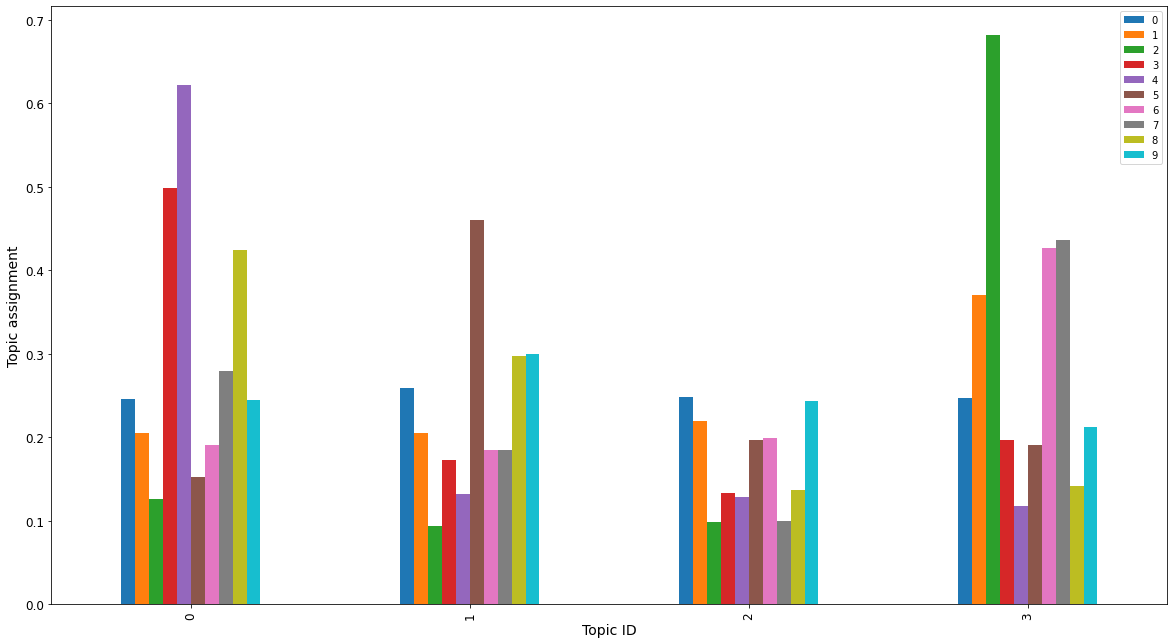

In [80]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

fs = 12
df=pd.DataFrame(predictions.T)
df.plot(kind='bar', figsize=(20, 11), fontsize=fs)
plt.ylabel('Topic assignment', fontsize=fs+2)
plt.xlabel('Topic ID', fontsize=fs+2)

Text(0.5, 0, 'Topic ID')

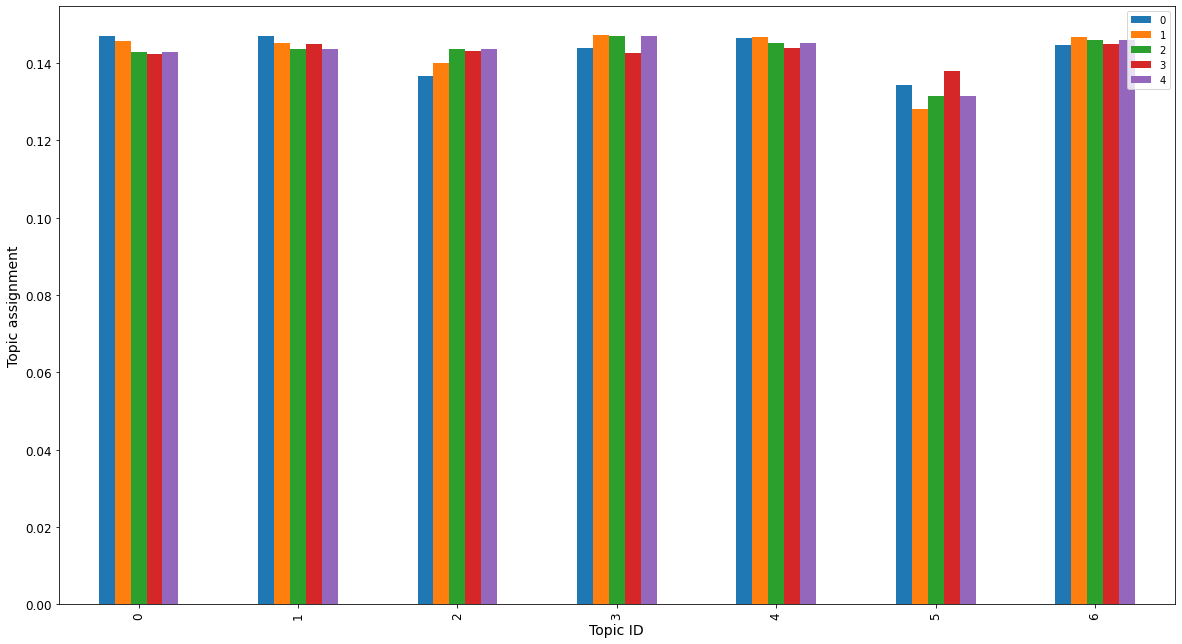

In [85]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

fs = 12
df=pd.DataFrame(predictions.T)
df.plot(kind='bar', figsize=(20, 11), fontsize=fs)
plt.ylabel('Topic assignment', fontsize=fs+2)
plt.xlabel('Topic ID', fontsize=fs+2)

## Load model artifacts stored in output directory
---

In [86]:
model_path = os.path.join(output_prefix, ntm._current_job_name, "output/model.tar.gz")
model_path

'sagemaker/regalado/output/ntm-2021-06-25-02-44-24-819/output/model.tar.gz'

In [87]:
boto3.resource("s3").Bucket(bucket).download_file(model_path, "downloaded_model.tar.gz")

In [88]:
!pwd

/home/ec2-user/SageMaker/my-experiments


In [89]:
tarfile.open('downloaded_model.tar.gz').extractall()

with zipfile.ZipFile('model_algo-1', 'r') as zip_ref:
    zip_ref.extractall('./')
    
model = mx.ndarray.load("params")
W = model["arg:projection_weight"]

## Model exploration
---

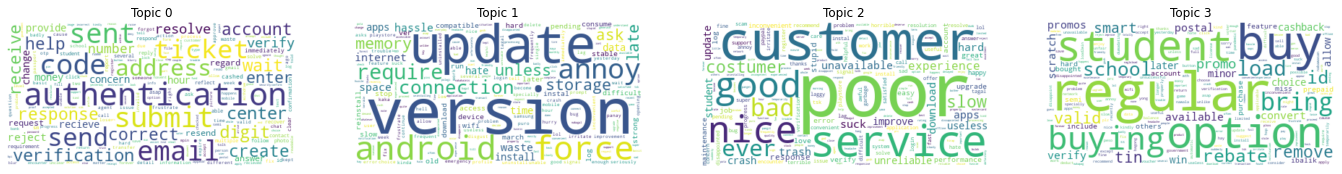

In [75]:
word_to_id = dict()

for i, v in enumerate(vocab_list):
    word_to_id[v] = i

limit = 30
n_col = 5
counter = 0

plt.figure(figsize=(30, 20))

for ind in range(num_topics):

    if counter >= limit:
        break

    title_str = "Topic {}".format(ind)

    pvals = mx.nd.softmax(W[:, ind]).asnumpy()
#     pvals = mx.nd.softmax(mx.nd.array(W[:, ind])).asnumpy()

    word_freq = dict()
    for k in word_to_id.keys():
        i = word_to_id[k]
        word_freq[k] = pvals[i]

    wordcloud = wc.WordCloud(background_color="white").fit_words(word_freq)

    plt.subplot(limit // n_col, n_col, counter + 1)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title_str)

    counter += 1

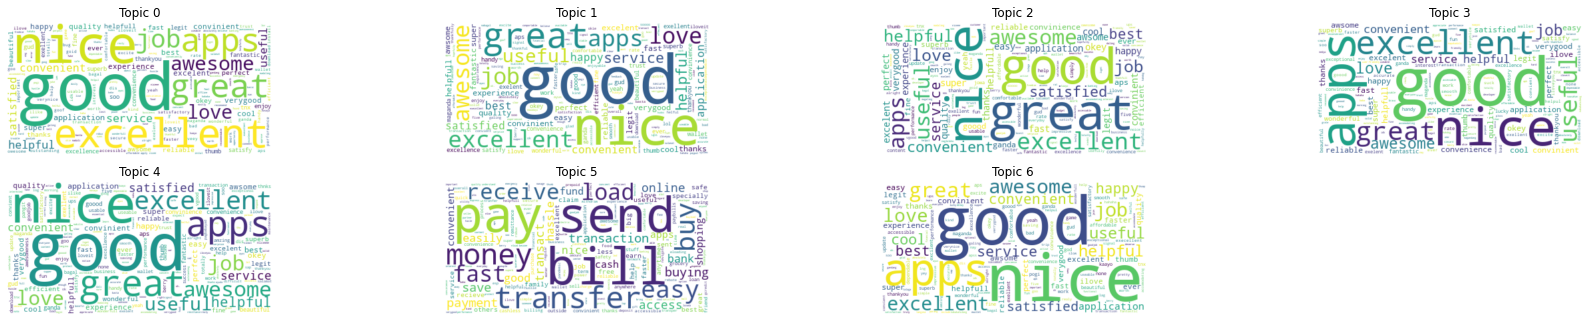

In [95]:
word_to_id = dict()

for i, v in enumerate(vocab_list):
    word_to_id[v] = i

limit = 30
n_col = 4
counter = 0

plt.figure(figsize=(30, 20))

for ind in range(num_topics):

    if counter >= limit:
        break

    title_str = "Topic {}".format(ind)

    # pvals = mx.nd.softmax(W[:, ind]).asnumpy()
    pvals = mx.nd.softmax(mx.nd.array(W[:, ind])).asnumpy()

    word_freq = dict()
    for k in word_to_id.keys():
        i = word_to_id[k]
        word_freq[k] = pvals[i]

    wordcloud = wc.WordCloud(background_color="white").fit_words(word_freq)

    plt.subplot(limit // n_col, n_col, counter + 1)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title_str)
    # plt.close()

    counter += 1